# HRS Spectrometer Neutrol network Model

In [208]:
import  pandas as pd
import numpy as np
import sklearn
import math
import matplotlib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import *
import math

## Load the Training dataset
- Merge Multi dataset
- randomize the order of the dataset
- [ftp data server](http://localhost/Data/spectro_nn/)

In [209]:
# files = ["../dataGenerator/result/PRex_DataSet_2239.csv",
#          "../dataGenerator/result/PRex_DataSet_2240.csv",
#          "../dataGenerator/result/PRex_DataSet_2241.csv",
#          "../dataGenerator/result/PRex_DataSet_2244.csv",
#          "../dataGenerator/result/PRex_DataSet_2245.csv",
#          "../dataGenerator/result/PRex_DataSet_2256.csv",
#          "../dataGenerator/result/PRex_DataSet_2257.csv"
#          ]

# large data set with all the features 
files = ["../dataGenerator/result/PRex_DataSet_Full_2239.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2240.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2241.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2244.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2245.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2256.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2257.csv"
         ]
li = []
for filename in files:
    print("Loading file {}".format(filename))
    df = pd.read_csv(filename)
    li.append(df)
data = pd.concat(li)
data.sample(frac=1) # sample the data with fraction 1. rearrange the data in random order
data.head()

Loading file ../dataGenerator/result/PRex_DataSet_Full_2239.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2240.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2241.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2244.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2245.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2256.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2257.csv


,evtID,runID,CutID,SieveRowID,SieveColID,bpmX,bpmY,x0th0y0ph0,x0th0y0ph1,x0th0y0ph2,...,x0th1y0ph1,x0th1y1ph0,x0th2y0ph0,x1th0y0ph0,x1th0y0ph1,x1th0y1ph0,x1th1y0ph0,x2th0y0ph0,targCalTh,targCalPh
0,0,2239,136,3,5,0.003794,-0.000501,1,-0.001618,0.000003,...,-8.923140e-07,0.000006,3.042260e-07,-0.014535,0.000024,-0.000161,-0.000008,0.000211,-0.000817,-0.010117
1,1,2239,130,4,4,0.003794,-0.000501,1,-0.009000,0.000081,...,6.038210e-05,-0.000057,4.501310e-05,-0.027425,0.000247,-0.000233,0.000184,0.000752,0.019571,-0.012569
2,2,2239,179,4,11,0.003794,-0.000501,1,0.014969,0.000224,...,-9.636200e-05,0.000094,4.144110e-05,-0.013932,-0.000209,0.000204,0.000090,0.000194,0.012775,0.014835
3,3,2239,142,2,6,0.003794,-0.000501,1,0.001385,0.000002,...,7.749150e-06,0.000017,3.129790e-05,-0.010740,-0.000015,-0.000032,-0.000060,0.000115,-0.014409,-0.003863
4,4,2239,127,1,4,0.003794,-0.000501,1,-0.004135,0.000017,...,-2.666770e-05,0.000078,4.159330e-05,-0.002179,0.000009,-0.000026,-0.000014,0.000005,-0.021206,-0.012569


In [210]:
# print(data[data.runID.eq(2240)])

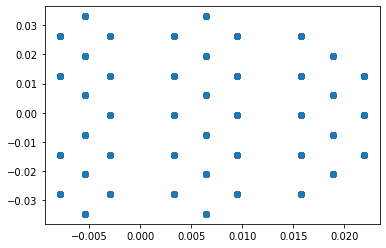

In [211]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
x = data[data.runID.eq(2241)]["targCalPh"]
y = data[data.runID.eq(2241)]["targCalTh"]
plt.scatter(x,y)
plt.show()

# New Function Used for Train the X, and Y model seperately

## Prepare the Data

In [212]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

### 1. prepare the training data

(221493, 24)

In [213]:
train_X, test_X, train_y, test_y = train_test_split(
    data.drop(labels=['evtID','runID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1),
    data[['targCalTh','targCalPh']],
    test_size=0.2,
    random_state=0)

n_feature = train_X.shape[1]
train_X.shape,train_y.shape,test_X.shape,test_y.shape

((177194, 15), (177194, 2), (44299, 15), (44299, 2))

In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OptNet(nn.Module):
    def __init__(self):
        super(OptNet,self).__init__()
        #TODO model, need to auto adapt to the training dataset
        self.fc1 = nn.Linear(n_feature, 2*n_feature)  # 6*6 from image dimension
        self.fc2 = nn.Linear(2*n_feature, n_feature)
        self.fc3 = nn.Linear(n_feature, n_feature//2)
        self.output = nn.Linear(n_feature//2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.output(x)
        return x



## Training on the $\theta_{targ}$

### 1. train the $\theta_{targ}$ model

In [215]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_trainTh = torch.tensor(train_X.to_numpy()).float()
y_trainTh = torch.tensor(train_y['targCalTh'].to_numpy()).float()
X_testTh  = torch.tensor(test_X.to_numpy()).float()
y_testTh  = torch.tensor(test_y['targCalTh'].to_numpy()).float()

In [216]:
import torch.optim as optim
thetaOptnet = OptNet()
thetaOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(thetaOptnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
for epoch in range(20):
    running_loss = 0.0
    for i in range(len(y_trainTh)):
        inputs = X_trainTh[i].to(device)
        labels = y_trainTh[i].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = thetaOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d, %6f] loss: %.9f' %
                  (epoch + 1, i + 1, optimizer.param_groups[0]['lr'],running_loss / 2000))
            running_loss = 0.0
    scheduler.step()

print("Finish Training Theta Parameters")
# save the training model
theta_model_PATH = './model/Theta_net.pth'
torch.save(thetaOptnet.state_dict(), theta_model_PATH)

/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/training_nn/venv/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/training_nn/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,  2000, 0.010000] loss: 0.000594929
[1,  4000, 0.010000] loss: 0.000465200
[1,  6000, 0.010000] loss: 0.000041477
[1,  8000, 0.010000] loss: 0.000036735
[1, 10000, 0.010000] loss: 0.000038290
[1, 12000, 0.010000] loss: 0.000033760
[1, 14000, 0.010000] loss: 0.000037768
[1, 16000, 0.010000] loss: 0.000033753
[1, 18000, 0.010000] loss: 0.000034883
[1, 20000, 0.010000] loss: 0.000026999
[1, 22000, 0.010000] loss: 0.000026527
[1, 24000, 0.010000] loss: 0.000022969
[1, 26000, 0.010000] loss: 0.000023913
[1, 28000, 0.010000] loss: 0.000022701
[1, 30000, 0.010000] loss: 0.000020207
[1, 32000, 0.010000] loss: 0.000021536
[1, 34000, 0.010000] loss: 0.000023587
[1, 36000, 0.010000] loss: 0.000018753
[1, 38000, 0.010000] loss: 0.000019771
[1, 40000, 0.010000] loss: 0.000020952
[1, 42000, 0.010000] loss: 0.000019607
[1, 44000, 0.010000] loss: 0.000019719
[1, 46000, 0.010000] loss: 0.000018648
[1, 48000, 0.010000] loss: 0.000021710
[1, 50000, 0.010000] loss: 0.000018317
[1, 52000, 0.010000] loss

## Training on the $\phi_{targ}$

### 2. train the $\phi_{targ}$ model

In [217]:
X_trainPh = torch.tensor(train_X.to_numpy()).float()
y_trainPh = torch.tensor(train_y['targCalPh'].to_numpy()).float()
X_testPh  = torch.tensor(test_X.to_numpy()).float()
y_testPh  = torch.tensor(test_y['targCalPh'].to_numpy()).float()

In [218]:
phiOptnet = OptNet()
phiOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(phiOptnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
for epoch in range(20):
    running_loss = 0.0
    for i in range(len(y_trainPh)):
        inputs = X_trainPh[i].to(device)
        labels = y_trainPh[i].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs =  phiOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d, %6f] loss: %.9f' %
                  (epoch + 1, i + 1, optimizer.param_groups[0]['lr'],running_loss / 2000))
            running_loss = 0.0
    scheduler.step()

print("Finish Training Theta Parameters")
# save the training model
phi_model_PATH = './model/Phi_net.pth'
torch.save(phiOptnet.state_dict(), phi_model_PATH)


[1,  2000, 0.010000] loss: 0.000237536
[1,  4000, 0.010000] loss: 0.000058384
[1,  6000, 0.010000] loss: 0.000010472
[1,  8000, 0.010000] loss: 0.000011728
[1, 10000, 0.010000] loss: 0.000009692
[1, 12000, 0.010000] loss: 0.000008513
[1, 14000, 0.010000] loss: 0.000009622
[1, 16000, 0.010000] loss: 0.000009812
[1, 18000, 0.010000] loss: 0.000009710
[1, 20000, 0.010000] loss: 0.000009922
[1, 22000, 0.010000] loss: 0.000009549
[1, 24000, 0.010000] loss: 0.000009358
[1, 26000, 0.010000] loss: 0.000009104
[1, 28000, 0.010000] loss: 0.000008952
[1, 30000, 0.010000] loss: 0.000009012
[1, 32000, 0.010000] loss: 0.000009457
[1, 34000, 0.010000] loss: 0.000008833
[1, 36000, 0.010000] loss: 0.000008089
[1, 38000, 0.010000] loss: 0.000008230
[1, 40000, 0.010000] loss: 0.000008649
[1, 42000, 0.010000] loss: 0.000008246
[1, 44000, 0.010000] loss: 0.000007984
[1, 46000, 0.010000] loss: 0.000010229
[1, 48000, 0.010000] loss: 0.000008059
[1, 50000, 0.010000] loss: 0.000007403
[1, 52000, 0.010000] loss

## Test the Training model

### 1. Seperate Test on the $\theta$ and $\phi$ on the test dataset

In [219]:
testNet_theta = OptNet()
testNet_theta.load_state_dict(torch.load(theta_model_PATH))

test_loss = 0
mseArr = []

with torch.no_grad():
    for i in range(len(y_testTh)):
        positions = X_testTh[i]
        labels = y_testTh[i]

        outputs = testNet_theta(positions)
        loss = criterion(outputs,labels)
        test_loss += loss
        mseArr.append(loss)
print('test_error is :{}   / {}'.format(test_loss,sum(mseArr)/len(mseArr)))

test_error is :0.16706085205078125   / 3.7712104585807538e-06


In [220]:
testNet_phi = OptNet()
testNet_phi.load_state_dict(torch.load(phi_model_PATH))

test_loss = 0
mseArr = []
with torch.no_grad():
    for i in range(len(y_testPh)):
        positions = X_testPh[i]
        labels = y_testPh[i]
        outputs = testNet_phi(positions)
        loss = criterion(outputs,labels)
        test_loss += loss
        mseArr.append(loss)
print('test_error is :{}   / {}'.format(test_loss,sum(mseArr)/len(mseArr)))

test_error is :0.03749479725956917   / 8.464027700938459e-07


### 2.2D histogram distribution test (Include all the training and test dataset)

In [221]:
def predictor(model_path,x_test):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = OptNet()
    net.load_state_dict(torch.load(model_path))
    net.to(device)
    res = torch.empty(0)
    with torch.no_grad():
        for i in range(len(x_test)):
            positions = x_test[i].to(device)
            outputs = net(positions).cpu()
            res = torch.cat((res,outputs))
    return res

In [237]:
alldatadf = data[data.runID.eq(2239)]
# get the theta and phi dimension and get the predictions
alldata = alldatadf.drop(labels=['evtID','runID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1)

alldatatensor = torch.tensor(alldata.to_numpy()).float()

theta = predictor(theta_model_PATH,alldatatensor)
phi   = predictor(phi_model_PATH,alldatatensor)

alldata

/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/training_nn/venv/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,x0th0y0ph0,x0th0y0ph1,x0th0y0ph2,x0th0y1ph0,x0th0y1ph1,x0th0y2ph0,x0th1y0ph0,x0th1y0ph1,x0th1y1ph0,x0th2y0ph0,x1th0y0ph0,x1th0y0ph1,x1th0y1ph0,x1th1y0ph0,x2th0y0ph0
0,1,-0.001618,0.000003,0.011066,-0.000018,0.000122,0.000552,-8.923140e-07,0.000006,3.042260e-07,-0.014535,0.000024,-0.000161,-0.000008,0.000211
1,1,-0.009000,0.000081,0.008514,-0.000077,0.000072,-0.006709,6.038210e-05,-0.000057,4.501310e-05,-0.027425,0.000247,-0.000233,0.000184,0.000752
2,1,0.014969,0.000224,-0.014659,-0.000219,0.000215,-0.006437,-9.636200e-05,0.000094,4.144110e-05,-0.013932,-0.000209,0.000204,0.000090,0.000194
3,1,0.001385,0.000002,0.003021,0.000004,0.000009,0.005594,7.749150e-06,0.000017,3.129790e-05,-0.010740,-0.000015,-0.000032,-0.000060,0.000115
4,1,-0.004135,0.000017,0.012108,-0.000050,0.000147,0.006449,-2.666770e-05,0.000078,4.159330e-05,-0.002179,0.000009,-0.000026,-0.000014,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29966,1,0.019872,0.000395,-0.014431,-0.000287,0.000208,-0.004714,-9.367920e-05,0.000068,2.222240e-05,-0.095544,-0.001899,0.001379,0.000450,0.009129
29967,1,0.025750,0.000663,-0.010561,-0.000272,0.000112,-0.003712,-9.559640e-05,0.000039,1.378200e-05,-0.198585,-0.005114,0.002097,0.000737,0.039436
29968,1,0.016607,0.000276,-0.017311,-0.000287,0.000300,-0.002346,-3.895980e-05,0.000041,5.503720e-06,-0.013187,-0.000219,0.000228,0.000031,0.000174
29969,1,0.016871,0.000285,-0.016077,-0.000271,0.000258,-0.002406,-4.058800e-05,0.000039,5.787870e-06,-0.012355,-0.000208,0.000199,0.000030,0.000153


In [238]:
alldatadf['predicPh'] =phi.numpy()
alldatadf['predicTh'] =theta.numpy()
alldatadf['residuTh'] = alldatadf['predicTh'] -alldatadf['targCalTh']
alldatadf['residuPh'] = alldatadf['predicPh'] -alldatadf['targCalPh']
alldatadf.head(5)

<ipython-input-238-0d6cd9716b20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldatadf['predicPh'] =phi.numpy()
<ipython-input-238-0d6cd9716b20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldatadf['predicTh'] =theta.numpy()
<ipython-input-238-0d6cd9716b20>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

,evtID,runID,CutID,SieveRowID,SieveColID,bpmX,bpmY,x0th0y0ph0,x0th0y0ph1,x0th0y0ph2,...,x1th0y0ph1,x1th0y1ph0,x1th1y0ph0,x2th0y0ph0,targCalTh,targCalPh,predicPh,predicTh,residuTh,residuPh
0,0,2239,136,3,5,0.003794,-0.000501,1,-0.001618,0.000003,...,0.000024,-0.000161,-0.000008,0.000211,-0.000817,-0.010117,-0.008519,-0.000137,0.000680,0.001598
1,1,2239,130,4,4,0.003794,-0.000501,1,-0.009000,0.000081,...,0.000247,-0.000233,0.000184,0.000752,0.019571,-0.012569,-0.011500,0.022290,0.002719,0.001069
2,2,2239,179,4,11,0.003794,-0.000501,1,0.014969,0.000224,...,-0.000209,0.000204,0.000090,0.000194,0.012775,0.014835,0.015959,0.011259,-0.001516,0.001124
3,3,2239,142,2,6,0.003794,-0.000501,1,0.001385,0.000002,...,-0.000015,-0.000032,-0.000060,0.000115,-0.014409,-0.003863,-0.002175,-0.014742,-0.000333,0.001688
4,4,2239,127,1,4,0.003794,-0.000501,1,-0.004135,0.000017,...,0.000009,-0.000026,-0.000014,0.000005,-0.021206,-0.012569,-0.011168,-0.020794,0.000412,0.001401


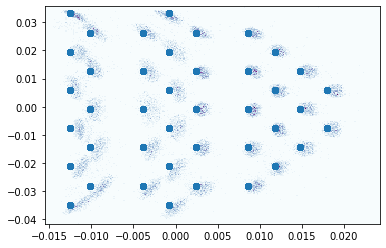

In [239]:
plt.hist2d(alldatadf['predicPh'],alldatadf['predicTh'],bins=300,cmap=plt.cm.BuPu)
plt.scatter(alldatadf['targCalPh'],alldatadf['targCalTh'])
plt.show()